In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from classifiers.datasets.dataloader import ToyBlochSphereLoader
from classifiers.datasets.datascaler import DataMultiScaler, DataScaler
from classifiers.quantum.qasvm import QASVM, BlochSphereQASVM, QASVM
from classifiers.visualization import Plot_Log_From_SPSA, Plot_Data
from classifiers.utils import get_loggers_add_handle
from qiskit.aqua.components.optimizers import SLSQP, SPSA
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.aqua.quantum_instance import QuantumInstance
from qiskit.providers.aer import QasmSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.aqua.algorithms.vq_algorithm import VQAlgorithm


In [4]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-kaist', group='internal', project='default')

In [5]:
X = np.array([[0, 0], [np.pi, 0]])
y = np.array([0, 1])

42


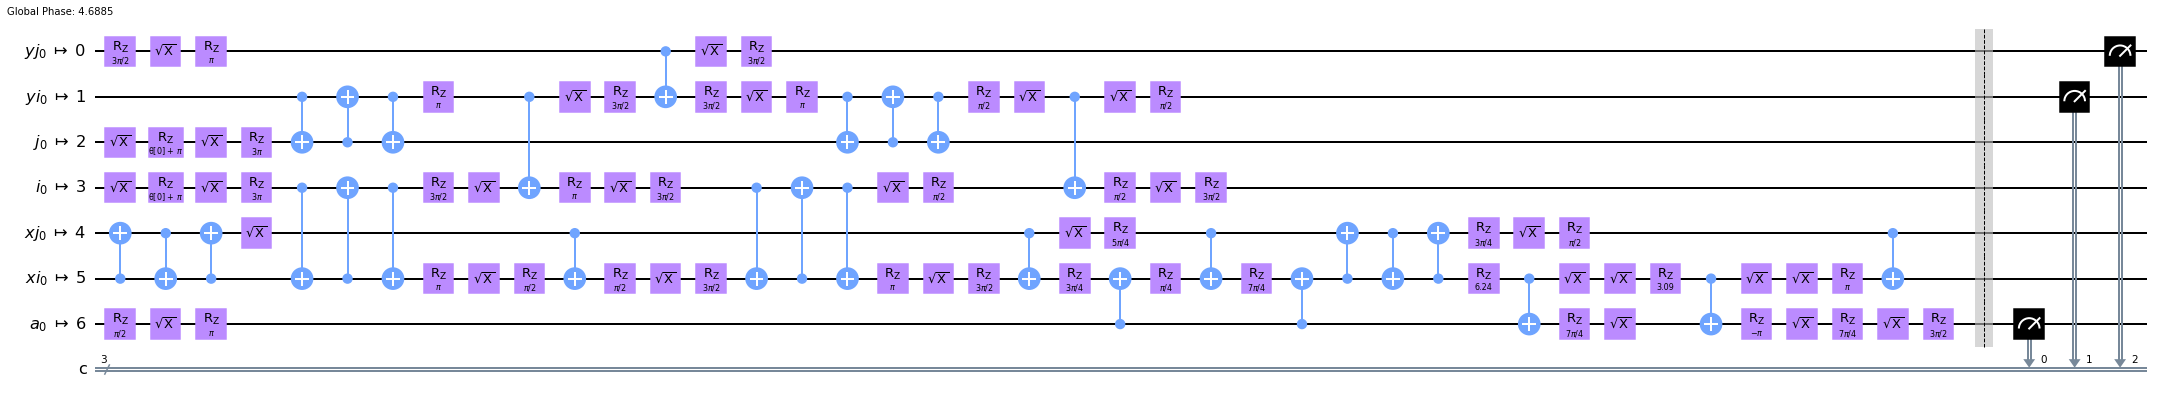

In [32]:
var_form = RealAmplitudes(1, reps=1, skip_final_rotation_layer=True)
optimizer = SPSA(maxiter=2**10, last_avg=2**7)
logger = get_loggers_add_handle(optimizer, VQAlgorithm)[0]
#quantum_instance = QuantumInstance(QasmSimulator(), shots=2**13, seed_simulator=10, seed_transpiler=10)
quantum_instance = QuantumInstance(QasmSimulator.from_backend(provider.get_backend('ibmq_casablanca')), shots=2**13, seed_simulator=None, seed_transpiler=10, measurement_error_mitigation_cls=CompleteMeasFitter)
quantum_instance.compile_config['layout_method'] = 'noise_adaptive'
quantum_instance.compile_config['optimization_level'] = 3
qasvm = BlochSphereQASVM(var_form=var_form, optimizer=optimizer, training_data=X, training_label=y, quantum_instance=quantum_instance, C=100, k=0.1).dual
del qasvm.quantum_instance.qjob_config['wait']
print(qasvm.quantum_instance.transpile(qasvm.second_order_circuit)[0].depth())
qasvm.quantum_instance.transpile(qasvm.second_order_circuit)[0].draw('mpl', fold=-1)

In [ ]:
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
kernel = Kernel('SingleQubit')
svm = BinarySVM(kernel, C=None, k=qasvm.k, mutation='REDUCED_QASVM')
svm.fit(X, y)

In [7]:
import dill
import pathlib
import uuid
qasvm.run()
dill.dump_session(logger.handlers[-1].baseFilename.split('.')[0]+'.dill')
#dill.dump_session(logger.handlers[-1].baseFilename.split('.')[0]+'.dill')

In [25]:
import dill

import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)
import pathlib

p = pathlib.Path.home()/'QUIC-Projects'/'exp_logs'
#dill.load_session(max(p.glob('*.dill'), key=lambda p: p.stat().st_ctime))
files = sorted(p.glob('*.dill'), key=lambda p: p.stat().st_ctime, reverse=True)
log_files = sorted(p.glob('*.log'), key=lambda p: p.stat().st_ctime, reverse=True)
dill.load_session(files[1])

In [27]:
print(qasvm)
print(qasvm.quantum_instance.run_config)


QASVM (qiskit)
	type: Dual
	backend: qasm_simulator(ibmq_casablanca)
	error mitigation: <class 'qiskit.ignis.mitigation.measurement.fitters.CompleteMeasFitter'>
	(C, k): (100, 0.1)
	accuracy: 1.0
RunConfig(max_credits=10, shots=8192)


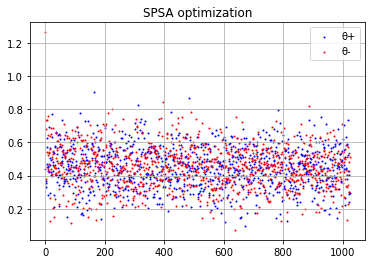

In [10]:
Plot_Log_From_SPSA(log_files[0]).plot(min_step=1, max_step=np.inf)

In [11]:
qasvm.accuracy(X, y)

1.0

In [12]:
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
kernel = Kernel('SingleQubit')
svm = BinarySVM(kernel, C=None, k=qasvm.k, mutation='REDUCED_QASVM')
svm.fit(X, y)


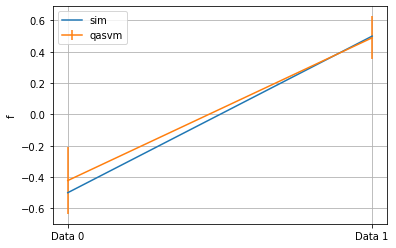

In [13]:
plt.plot(svm.f(X), label='sim')
res = np.array([qasvm.f(X) for _ in range(10)])
plt.errorbar(range(len(res.mean(axis=0))), res.mean(axis=0), yerr=2*res.std(axis=0), label='qasvm')
plt.xticks(range(2), [f'Data {i}' for i in range(4)])
plt.ylabel('f')
plt.legend()
plt.grid()

In [14]:
import re
q = re.compile('Objective function at theta[+] for step # \d+: -?\d+[.]\d+')
s = 'Objective function at theta+ for step # 12: -0.78765678'
q.search(s)

<re.Match object; span=(0, 55), match='Objective function at theta+ for step # 12: -0.78>

In [15]:
from classifiers.utils import clean_exp_logs
clean_exp_logs()

rm /home/quic/QUIC-Projects/exp_logs/210303-220039-8ed27ec6-4e85-4ae3-9401-a5127abcec17.log
rm /home/quic/QUIC-Projects/exp_logs/210303-220114-a43229a8-4cf8-40db-ac4e-cdc798544223.log
